In [1]:
import pandas as pd
import numpy as np
import pickle
import math
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.neural_network import MLPClassifier
from sklearn.mixture import GaussianMixture
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, average_precision_score, f1_score, silhouette_score, v_measure_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap
from sklearn.random_projection import GaussianRandomProjection
from sklearn.decomposition import PCA, FastICA
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
import matplotlib.pyplot as plt
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
seed = 0
dataset1_df = pd.read_csv("dataset1/processed_full_data.csv")
dataset2_df = pd.read_csv("dataset2/processed_full_data.csv")
dim_dict = {'pca': [10,3],
            'ica': [10,10],
            'rp': [10,10],
            'isomap': [5,6]}

In [3]:
def fit_pca(X, dim_dict, dataset_idx, seed):
    print('######  Performing PCA  #######')
    pca = PCA(n_components=dim_dict['pca'][dataset_idx], random_state = seed)
    trans_X = pca.fit_transform(X)    
    return trans_X

def fit_ica(X, dim_dict, dataset_idx, seed):
    print('#########  Performing ICA  #########')
    ica = FastICA(n_components=dim_dict['ica'][dataset_idx], random_state = seed)
    trans_X = ica.fit_transform(X)    
    return trans_X

def fit_rp(X, dim_dict, dataset_idx, seed):
    print('#########  Performing RP  #########')
    rp = GaussianRandomProjection(n_components=dim_dict['rp'][dataset_idx], random_state = seed)
    trans_X = rp.fit_transform(X)    
    return trans_X

def fit_isomap(X, dim_dict, dataset_idx, seed):
    print('#########  Performing Isomap  #########')
    isomap = Isomap(n_components=dim_dict['isomap'][dataset_idx])
    trans_X = isomap.fit_transform(X)    
    return trans_X

def fit_kmeans(trans_X, K, dataset_idx, verbose=True, plot=True):
    if verbose:
        print('Performing KMeans')
    silhouette_score_values = []
    v_measures = []
    sum_sq_dists = []
    cluster_labels_list = []
    for k in K:
        kmeans = KMeans(n_clusters=k, max_iter=300, random_state=seed, n_jobs=-1, algorithm='auto').fit(trans_X)
        sum_sq_dists.append(kmeans.inertia_)
        cluster_labels = kmeans.predict(trans_X)
        
        cluster_labels_list.append(cluster_labels)

        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_score_values.append(silhouette_avg)
        
        v_measure = v_measure_score(Y, cluster_labels)
        v_measures.append(v_measure)
    
    if plot:
        plt.suptitle(f'K-means clustering metric for dataset {idx+1}', y=1.02)

        plt.subplot(311)
        plt.plot(K, silhouette_score_values)
        plt.title("Silhouette score values vs Numbers of Clusters")
        plt.show()

        plt.subplot(312)
        plt.plot(K, v_measures)
        plt.title("V measure scores vs Number of Clusters")
        plt.show()

        plt.subplot(313)
        plt.plot(K, sum_sq_dists, 'bx-')
        plt.xlabel('k')
        plt.xticks(K)
        plt.title('Sum of squared distances vs Number of Clusters (Elbow method)')
        plt.show()
    
    return cluster_labels_list
    
def fit_EM(transX, K, dataset_idx, verbose=True, plot=True):
    if verbose:
        print('Performing EM')
    aic_list = []
    bic_list = []
    cluster_labels_list = []
    for k in K:
        EM = GaussianMixture(n_components=k, n_init = 5, random_state=seed)
        EM.fit(X)
        cluster_labels = EM.predict(X)
        cluster_labels_list.append(cluster_labels)
        aic = EM.aic(X)
        aic_list.append(aic)
        bic = EM.bic(X)
        bic_list.append(bic)
    
    if plot:
        plt.suptitle(f'EM clustering metric for dataset {idx+1}', y=1.02)

        plt.subplot(211)
        plt.plot(K, aic_list)
        plt.title("AIC values vs Numbers of Clusters")
        plt.show()

        plt.subplot(212)
        plt.plot(K, bic_list)
        plt.title("BIC values vs Number of Clusters")
        plt.show()
    
    return cluster_labels_list

##############   Analyzing dataset 1   #############
######  Performing PCA  #######
Performing KMeans


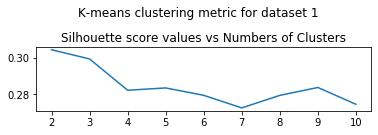

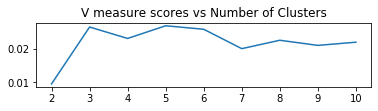

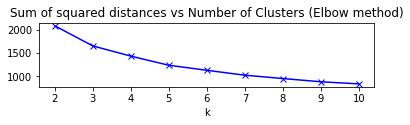

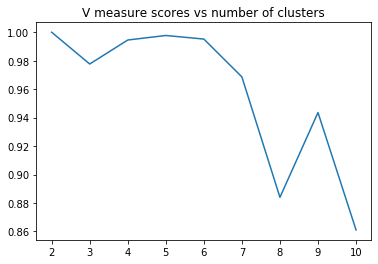

Performing EM


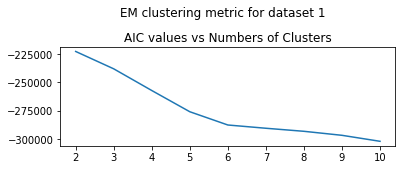

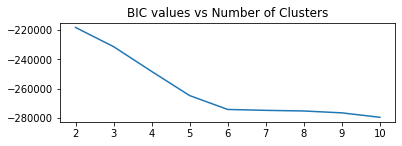

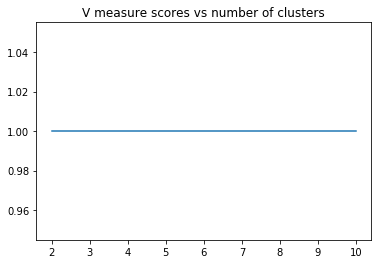

#########  Performing ICA  #########
Performing KMeans


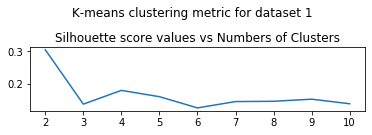

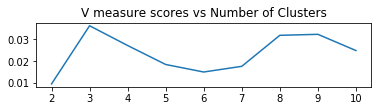

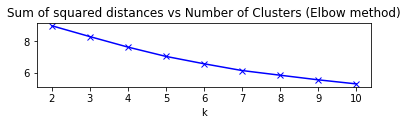

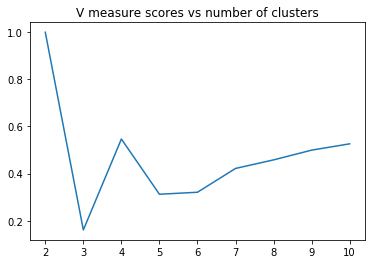

Performing EM


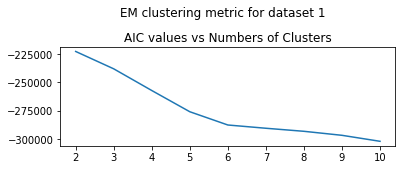

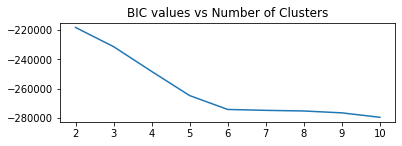

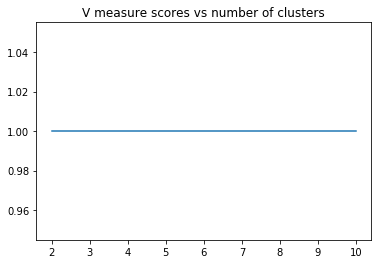

#########  Performing RP  #########
Performing KMeans


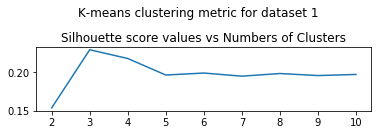

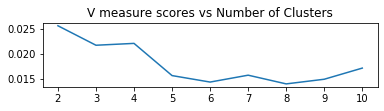

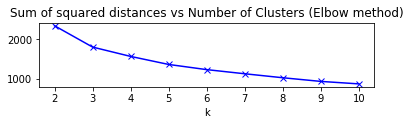

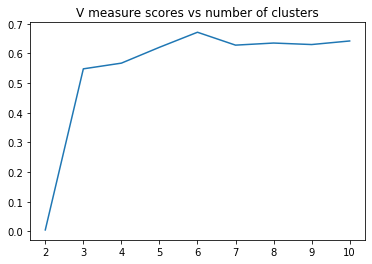

Performing EM


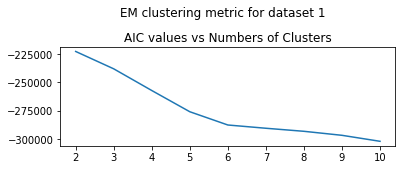

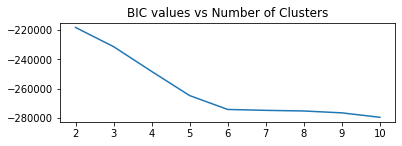

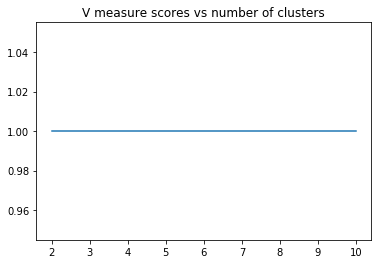

#########  Performing Isomap  #########
Performing KMeans


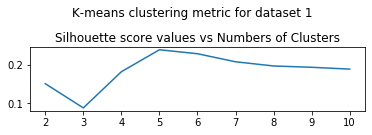

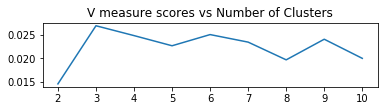

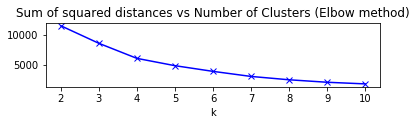

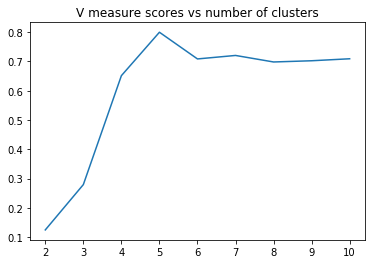

Performing EM


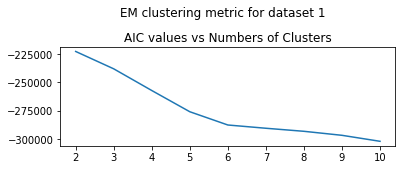

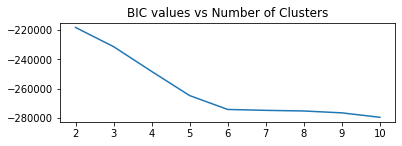

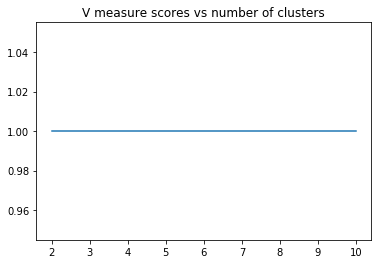

##############   Analyzing dataset 2   #############
######  Performing PCA  #######
Performing KMeans


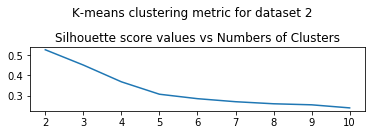

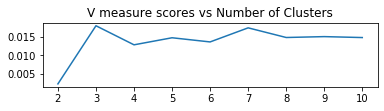

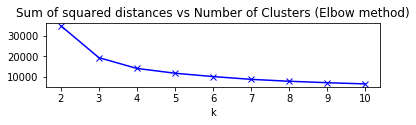

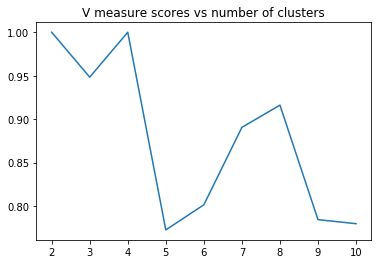

Performing EM


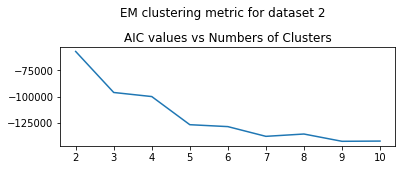

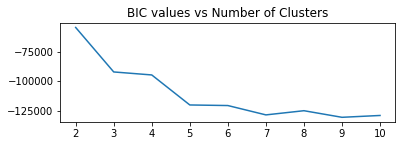

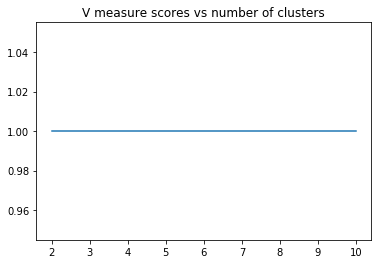

#########  Performing ICA  #########
Performing KMeans


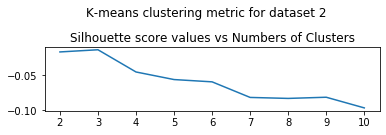

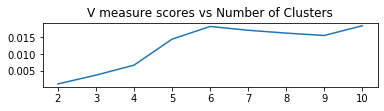

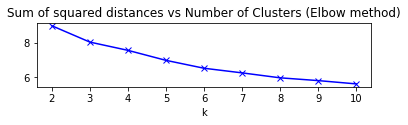

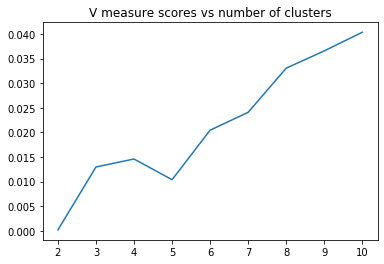

Performing EM


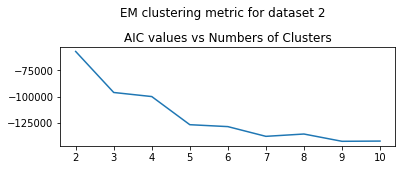

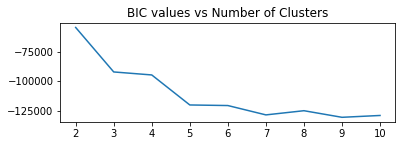

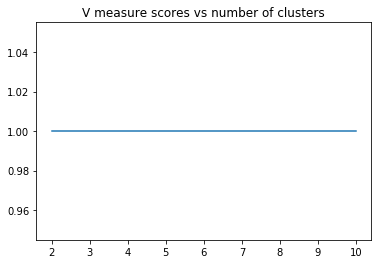

#########  Performing RP  #########
Performing KMeans


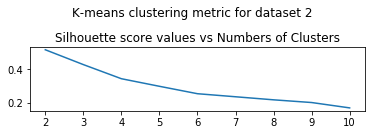

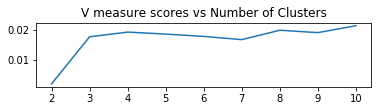

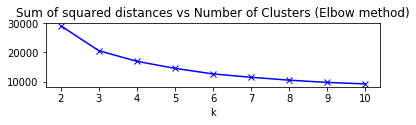

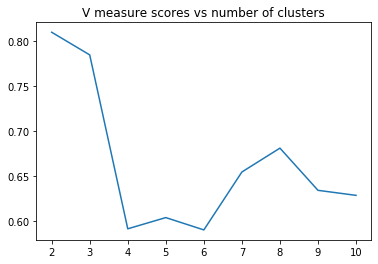

Performing EM


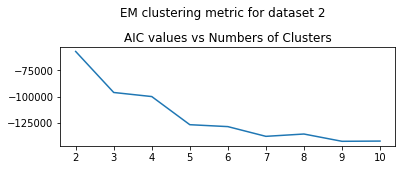

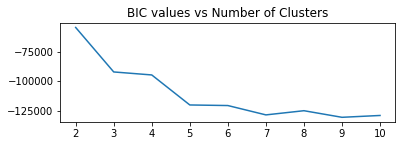

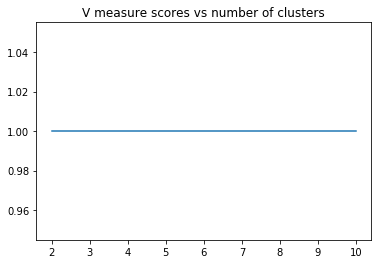

#########  Performing Isomap  #########
Performing KMeans


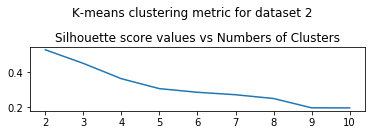

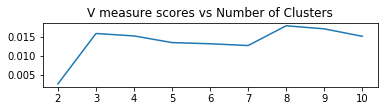

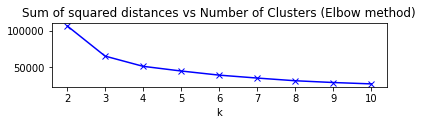

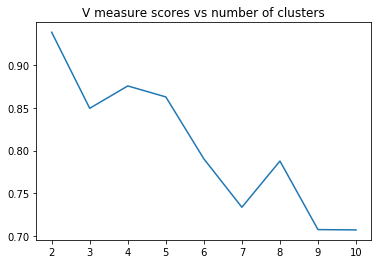

Performing EM


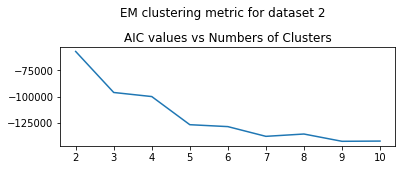

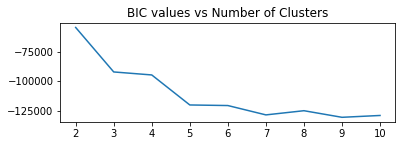

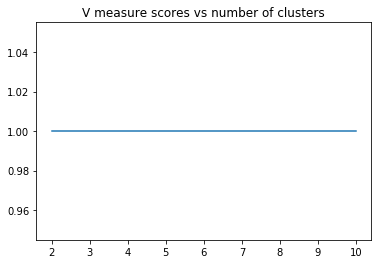

In [5]:
for idx, df in enumerate([dataset1_df, dataset2_df]):
    print(f'##############   Analyzing dataset {idx+1}   #############')
    features = list(set(df.columns) - set(['label']))
    X = df[features]
    Y = df['label']
    K = np.arange(2,11)
    
    for dim_reduction_fn in [fit_pca, fit_ica, fit_rp, fit_isomap]:
        trans_X = dim_reduction_fn(X, dim_dict, idx, seed)
        for clustering_fn in [fit_kmeans, fit_EM]:
            #original
            ori_cluster_labels_list = clustering_fn(X, K, idx, verbose=False, plot=False)
            # after we reduce dimensions
            cluster_labels_list = clustering_fn(trans_X, K, idx, verbose=True, plot=True)
            v_meas_list = []
            for m in range(len(cluster_labels_list)):
                v_meas_score = v_measure_score(ori_cluster_labels_list[m], cluster_labels_list[m])
                v_meas_list.append(v_meas_score)
            plt.figure()
            plt.plot(K, v_meas_list)
            plt.title('V measure scores vs number of clusters')
            plt.show()